# Galaxy photometric redshift estimation with linear regression


### Background

To create a [3D map of the Universe](https://www.youtube.com/watch?v=08LBltePDZw) we need to measure 3 coordinates of galaxies. The celestial coordinates on the sky are easy to get, but measuring their distance is much harder. Since the Universe is expanding, the photons from a far away galaxy are also expanded during their long journey. The expansion of photons is the redshift: well known spectral features are shifted to redder colors. According to [Hubble's law](https://en.wikipedia.org/wiki/Hubble%27s_law), which the distance is approximately proportional to the [redshift](https://en.wikipedia.org/wiki/Redshift). 

Since galaxies are very faint, it takes a lot of observing time to spread their light in spectrographs and get high resolution spectrum. So, we have _spectroscopic redshift_ only for a limited set of them, for others, redshift may be estimated form _broadband photometry_, the brightness of galaxies took by few color filters. Estimating the redshift from this limited set is called _photometric redshift estimation_. 

### About the assignment
In this notebook you will learn about linear regression and using it for predicting photometric redshifts of galaxies.

The notebook has three main parts:
- Implement linear regression model
- Calculate the gradients of linear regression
- Train the model with gradient descent algorithm

Run the cell bellow to import the required packages:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

def evaluate(pred,Y):
    return np.sqrt(np.mean((pred - Y) ** 2))

In [3]:
with open("photoz_data.pkl","rb") as f:
    data = pickle.load(f)
    X    = data["X"]
    Y    = data["Y"]

Isplit = int(len(X)*0.8)
Xtrain = X[:Isplit]
Ytrain = Y[:Isplit]
Xtest  = X[Isplit:]
Ytest  = Y[Isplit:]

Ytrain = Ytrain.reshape((-1,1))
Ytest  = Ytest.reshape((-1,1))

print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(16000, 4)
(16000, 1)
(4000, 4)
(4000, 1)


## Linear regression
### Model

Linear regression is a linear mapping from  ${\Bbb R}^N$ to ${\Bbb R}^K$. The formal definition is the following:
\begin{align}
f:{\Bbb R}^N\rightarrow{\Bbb R}^K\\
f(x) = Wx+b,
\end{align}
where $x$ is a $N$ dimensional row vector, $W$ is a $K\times N$ matrix, $b$ is $K$ dimensional row vector and the result $f(x)$ is $K$ dimensional row vector. With matrix notation:

\begin{equation}
f(x)
= 
\begin{bmatrix} 
    W_{11} & W_{12} & \dots  & W_{1N}\\
    W_{21} & W_{22} & \dots  & W_{2N}\\
    \vdots & \ddots & \ddots & \vdots \\
    W_{K1} & W_{K2} &\dots   & W_{KN} 
    \end{bmatrix}
\begin{bmatrix} 
    x_{1} \\
    x_{2} \\
    \vdots  \\
    x_{N} 
\end{bmatrix}   
+
\begin{bmatrix} 
    b_{1} \\
    b_{2} \\
    \vdots  \\
    b_{K} 
\end{bmatrix}
\end{equation}


As you can see above, our data has a little bit different shape:
\begin{equation}
X=\begin{bmatrix} 
    X_{11} & X_{12} & X_{13}  & X_{14}\\
    X_{21} & X_{22} & X_{23}  & X_{24}\\
    \vdots &  \vdots &  \vdots & \vdots \\
    X_{m1} & W_{m2} &W_{m3}   & m_{m4} 
    \end{bmatrix},\;\;\;\;\;\;\;
Y = \begin{bmatrix} 
    Y_{1} \\
    Y_{2} \\
    \vdots  \\
    Y_{m} 
\end{bmatrix}
\end{equation}

What you can see here, is that we have stacked different data points together forming $X$ data matrix. Every row of this matrix contain a single data point (so there is $m$ training example), and each column contains one dimension of our source space (so $N=4$). The target value is $m$ dimensional row vector, so each row contains the target value for one data point (this means $K=1$).


You will have to evaluate the $f(x)$ function (this function expects $N=4$ dimensional row vector) for every data point.
What you can do, loop over the rows of $X$, get one column, transpose it and evaluate the function.

```python
for i in range(X.shape[0]):
    x = X[i,:].T
    prediction = f(x)
```

But this is not efficient (in case deep neural networks it will be too slow: no cat recognition in this way). To make it efficient we have to vectorize our model. In this case this will be easy.

If you transpose $X$ you get $N\times m$ matrix. If you multiply this with $K\times N$ matrix, you will get $K\times m$ matrix. Every column of the result matrix contains the result for one data point. So what we just did? We calculated the first term of the model ($Wx$) for every data point in a single matrix multiplication. 

What about the bias term ($+b$)? The result of $WX$ is a $K\times m$ matrix and we try to add $K\times 1$ row vector to this matrix. This is clearly a mathematical error. We need to transform the $b$ vector to a $k\times m$ matrix, simply by copying the $b$ row vector $m$ times and forming a matrix. In python you won't have to do this, because of <b>broadcasting</b>. When you try to add $K\times 1$ vector to $K\times m$ matrix, python will invoke broadcasting, and will transform $K\times 1$ vector to $K\times m$ matrix by copying the vector $m$ times. (This also works if you try to add $1\times K$ vector $m \times K$ matrix).

So in case of $N=4,K=1$ the vectorization looks like this ($W$ is $1 \times 4$ column vector, $b$ is $1\times 1$ row vector :) ):

\begin{equation}
f(X)=WX+b=
\begin{bmatrix} 
    W_{11} & W_{12} &  W_{13}   &  W_{14} 
\end{bmatrix}
\begin{bmatrix} 
    X_{11} & X_{21} & \dots  & X_{m1}\\
    X_{12} & X_{22} & \dots  & X_{m2}\\
    X_{13} & X_{23} & \dots  & X_{m3}\\
    X_{14} & X_{24} & \dots  & X_{m4}
\end{bmatrix}
+b
\end{equation}

We transform the result, just to be in the same shape as the target values.

In [4]:
def linreg_model(W, b, X):
    X = X.T
    Y = np.matmul(W,X)+b
    return Y.T

In [8]:
np.random.seed(10)
W = np.random.randn(2,3)
b = np.random.randn(2,1)
X_ = np.random.randn(4,3)
Y_ = linreg_model(W,b, X_)
print(Y_)

[[ 0.00429143 -0.17460021  0.43302619]
 [ 1.20303737 -0.96506567  1.02827408]
 [ 0.22863013  0.44513761 -1.13660221]
 [ 0.13513688  1.484537   -1.07980489]]
[[-0.52286066 -0.31178875]
 [-0.41192633 -1.24161289]
 [ 2.64485535  1.20166258]
 [ 3.17604692  1.80736371]]


Expected result:
\begin{equation}
       [[-0.52286066, -0.31178875],\\
       [-0.41192633, -1.24161289],\\
       [ 2.64485535,  1.20166258],\\
       [ 3.17604692,  1.80736371]]
\end{equation}

### Loss function

In regression, we use the mean squared error loss function, which is defined with the following equation:
\begin{equation}
L(W,b) = \frac{1}{2m}\sum_{i=1}^{m} \left \| f(x^{(i)})-Y^{(i)}\right \|^2
\end{equation}

To calculate the sum efficiently we have to vectorize this equation (reminder: our vectorized $f$ can take $X$ and will calculate the prediction for all the data, the result will be the same shape as $Y$). Because $K=1$, $Y$ and $f(X)$ is a $m$ dimensional row vector. The vectorized loss function is the following:

\begin{equation}
L(W,b) = \frac{1}{2m} \big(f(X)-Y\big)^T \big(f(X)-Y\big)
\end{equation}

In [5]:
def linreg_loss(prediction, Y):
    m = Y.shape[0]

    difference = prediction-Y
    loss       = np.matmul(difference.T, difference)/float(2*m)

    return loss[0,0]

In [6]:
np.random.seed(10)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
X_ = np.random.randn(4,3)
Y_ = np.random.randn(4,1)
Z_ = linreg_model(W,b,X_)
print(linreg_loss(Z_, Y_))

0.858678507262


### Gradients

We can imagine the linear regression model as a two node computational graph:
<img src="./images/LinearRegressionForwardPass.png" width="70%" />

To evaluate the model, we input X, Y and we do a forward pass on the graph. To calculate the gradients, we do a backward pass on the graph, as the figure shows bellow:
<img src="./images/LinearRegressionBackwardPass.png" width="70%" />


In [7]:
def linreg_gradients(Z, X, Y):
    m = Z.shape[0]
    K = Z.shape[1]
    N = X.shape[1]
    
    
    # initialize them with zeros
    dLdW = np.zeros((K,N))
    dLdb = np.zeros((K,1))
    
    #calculate the dLdZ
    dLdZ = (Z-Y)/float(m)
    
    #calculate the derivatives
    dLdW = np.matmul(dLdZ.T, X)
    dLdb = np.sum(dLdZ)
    
    return (dLdW, dLdb)

In [8]:
np.random.seed(10)
X_ = np.random.randn(4,3)
Y_ = np.random.randn(4,1)
Z_ = np.random.randn(4,1)
print(linreg_gradients(Z_,X_,Y_))

(array([[ 0.09469632, -0.30041199, -0.23023634]]), -0.33342734193801266)


### Gradient descent


To train the model we will use gradient descent. The algorithm is the following:
```pseudo
W = random(W_shape)
b = random(b_shape)
repeat{
    W = W - alpha * dLdW
    b = b - alpha * dLdb
}
```

In [9]:
def linreg_fit(X,Y, num_iteration=1000, learning_rate=0.1):
    m = Y.shape[0]
    K = Y.shape[1]
    N = X.shape[1]
    np.random.seed(20)
    
    
    # initialize the weights
    W = np.random.randn(K,N)
    b = np.random.randn(K,1)
    
    train_loss = []
    
    # Gradient descent
    for i in range(num_iteration):
        
        # Do a forward step on the computational graph (1 line)
        Z = linreg_model(W, b, X)
        
        # Evaluate the loss
        loss = linreg_loss(Z, Y)
        
        # Calculate the gradients (1 line)
        dLdW, dLdb = linreg_gradients(Z, X, Y)
        
        # Update the weights
        W = W - learning_rate*dLdW
        b = b - learning_rate*dLdb
        
        train_loss.append(loss)
        if i%100==0:
            print("* iteration=%d,loss= %f"%(i, loss))
        
    return (W, b, train_loss)

In [10]:
W, b, train_loss = linreg_fit(Xtrain,Ytrain)

* iteration=0,loss= 0.338647
* iteration=100,loss= 0.057213
* iteration=200,loss= 0.034701
* iteration=300,loss= 0.023107
* iteration=400,loss= 0.016392
* iteration=500,loss= 0.012274
* iteration=600,loss= 0.009675
* iteration=700,loss= 0.008011
* iteration=800,loss= 0.006936
* iteration=900,loss= 0.006240


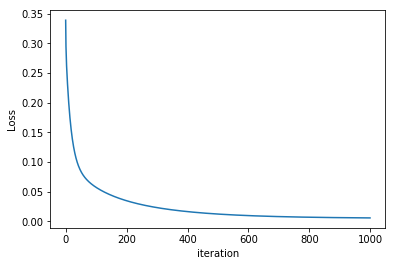

In [11]:
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

Expected output: loss decreasing as function of iterations

#### Testing the model

In [12]:
Ypred_test = linreg_model(W, b, Xtest)
rms = evaluate(Ypred_test, Ytest)

print("RMS error on test set = {0:.2f}".format(rms))

RMS error on test set = 0.10


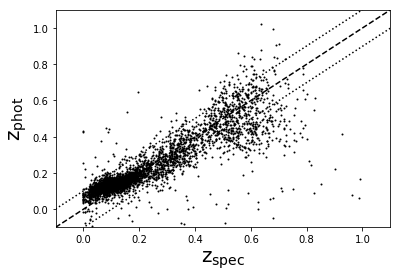

In [24]:
axis_lim = np.array([-0.1, 1.1])


plt.scatter(Ytest, Ypred_test, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=20)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=20)

plt.show()
